In [31]:
import matplotlib.pyplot as plt
import stompy.model.delft.dflow_model as dfm
import stompy.model.hydro_model as hm
import xarray as xr
from stompy import utils
import numpy as np
import pandas as pd
from stompy.plot import plot_wkb

import six

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib notebook

In [32]:
import sfb_csc

In [33]:
runs=[
    #dict(run_dir="data_3d_2019_summer-v009", label="3D"),
    #dict(run_dir="data_2d_2019_summer-v008", label="2D"),
    # switch tides to PR
    #dict(run_dir="data_2d_2019_summer-v010", label="2D"),
    # in progress:
    # v011: use that last run to set lag and amplitude at SF
    #dict(run_dir="data_2d_2019_summer-v011", label="2D"),
    #dict(run_dir="data_2d_2019_summer-v012", label="2D"),
    # v012: bring the old tuned roughness back in. Had been
    #   running [accidentally] with uniform 0.02 roughness
    # v015: more roughness everywhere
    #dict(run_dir="data_2d_2019_summer-v015", label="2D"),
    # v016: bedlevtype=3. WSE amplitude about the same, lag
    # got worse.
    # dict(run_dir="data_2d_2019_summer-v016", label="2D"),
    # v017: bedlevtype=4 
    # Similarly bad for lag.
    # dict(run_dir="data_2d_2019_summer-v017", label="2D"),
    # v019: extract bathy at nodes, no bias. Lags are better
    # than v016, v017, but not good.
    #dict(run_dir="data_2d_2019_summer-v019", label="2D"),
    # v020: keep node sampling but go back to bedlevtype=6
    # This is getting pretty close. Can decrease friction some
    # throughout the Bay. And check the lag code to see if it
    #  is using R or R^2. It's coming up with ~6+h lags, and negative
    #  r.
    # dict(run_dir="data_2d_2019_summer-v020", label="2D"),
    # v021: reduce global friction to 0.023. Deep bias in intertidal
    # areas, direct sample in subtidal areas. Fix the sign on
    # some transects. No change in ocean lag/amplitude, but that's probably
    # needed.
    #dict(run_dir="data_2d_2019_summer-v021", label="2D"),
    # v022: minor tweak to amplitude, phase of BC. also slight decrease in
    # sac, south delta, south bay friction
    # dict(run_dir="data_2d_2019_summer-v022", label="2D"),
    # v023: various tweaks to friction, and fix the sign issue with the 
    # lag.
    dict(run_dir="data_2d_2019_summer-v023", label="2D")
]
runs=pd.DataFrame(runs)

In [34]:
six.moves.reload_module(dfm)
six.moves.reload_module(sfb_csc)

runs['model'] = runs['run_dir'].apply(lambda r: sfb_csc.SfbCsc.load(r))

In [35]:
# Dev for stage comparisons
his_ds=runs.loc[0,'model'].his_dataset()


In [36]:
# cross_section geom is coming up strange. Either a bug in DFM snapping or
# output. Some of the coordinates are zero in the hist file.

In [37]:
import stompy.model.data_comparison as dc

class ModelData: 
    data_start=None # will be set from model
    data_stop =None
    def __init__(self,model,**kw):
        utils.set_keywords(self,kw)
        # Might transition this to better caching at some point.
        self.model=model
        self.his=self.model.his_dataset()
        self.data_start=self.his.time.values[0]
        self.data_stop =self.his.time.values[-1]


class DFMStage(ModelData):
    station=None
    
    def __init__(self,model,station):
        super().__init__(model)
        self.station=station
        
    def src_data(self):
        if self.station not in self.his.stations:
            print(f"stations={self.station} not present in his file")
            return None

        da=self.his.sel(stations=self.station)['waterlevel']
        da=da.assign_coords(label='Pred')
        return da
    
    def plot_xy(self):
        if self.station not in self.his.stations: return None
        return [self.his.station_x_coordinate.sel(stations=self.station).values,
                self.his.station_y_coordinate.sel(stations=self.station).values]
    
class DFMFlow(ModelData):
    cross_section=None
    location=None
    
    def __init__(self,model,cross_section,**kw):
        self.cross_section=cross_section
        super().__init__(model,**kw)
        
    def src_data(self):
        if self.cross_section not in self.his.cross_section:
            print(f"cross_section={self.cross_section} not present in his file")
            return None
        da=self.his.sel(cross_section=self.cross_section)['cross_section_discharge']
        da=da.assign_coords(label='Pred')
        return da
    
    def plot_xy(self):
        if self.location is None:
            if self.cross_section not in self.his.cross_section: return None
            linestring=self.his.cross_section_geom.sel(cross_section=self.cross_section).item()
            #return np.array(linestring.coords).mean(axis=0)
            return np.array(linestring.coords)[0,:] # some features have trailing 0?
        elif isinstance(self.location,str):
            # interpret as a station with the given name
            if self.location not in self.his.stations: return None
            return [self.his.station_x_coordinate.sel(stations=self.location).values,
                    self.his.station_y_coordinate.sel(stations=self.location).values]
        else: # assume [x,y]
            return self.location
        
class StationCompare:
    """
    Comparison plots and helpers for station-oriented data
    """
    name=None
    reference=0 # control metric calculation 
    predicted=1 # 
    
    def __init__(self,sources,**kw):
        self.sources=sources
        self.data=None
        utils.set_keywords(self,kw)
        
        if self.name is None:
            self.name=self.sources[0].name    
        
    def plot_xy(self):
        """
        return [x,y] for where this point[ish] comparison should be
        plotted.
        """
        for source in self.sources:
            try:
                xy=source.plot_xy()
                if xy is not None:
                    return xy
            except AttributeError:
                pass
        print("No sources provided a location")
        return [np.nan,np.nan]
        
    def assemble_data(self):
        if self.data is not None:
            return self.data
        
        # See which sources already have a date range.
        # choose the final date range based on those.
        starts=[]
        stops =[]
        for source in self.sources:
            if source.data_start is not None:
                starts.append(source.data_start)
            if source.data_stop is not None:
                stops.append(source.data_stop)
        # will need better logic than this. Maybe test for model vs obs.
        start=min(starts)
        stop =max(stops)
        print(f"Inferred time period: {start} to {stop}")
        
        data=[]
        
        labels={}
        for src_i,source in enumerate(self.sources):
            if source.data_start is None:
                source.data_start=start
            if source.data_stop is None:
                source.data_stop =stop
            try:
                da=source.src_data()
            except hm.MissingBCData:
                da=None

            if da is None:
                data.append(None)
                continue
                
            if 'label' not in da.coords:
                if isinstance(source,hm.BC):
                    label="Obs"
                elif isinstance(source,ModelData):
                    label="Pred"
            else:
                label=da.label.item()
                
            if label in labels:
                label=label+str(src_i)
            labels[label]=True
            data.append(da.assign_coords(label=label))
        self.data=data
        return self.data
    
    def calc_metrics(self):
        data=self.assemble_data() # list of dataarrays
        if data[self.reference] is None or data[self.predicted] is None:
            return dict(error="no data")
        else:
            return dc.calc_metrics(data[self.predicted],data[self.reference],combine=True)

    def figure(self):
        self.assemble_data()
        if any([d is None for d in self.data]):
            print("No data - skipping figure")
            return None
        self.combined=dc.combine_sources(self.data)
        fig=dc.calibration_figure_3panel(all_sources=self.data,
                                         metric_x=self.predicted,metric_ref=self.reference,
                                         combined=self.combined)
        fig.axes[0].legend(title=self.name,loc='upper left',bbox_to_anchor=(1,1),
                           frameon=0)
        fig.subplots_adjust(right=0.85,left=0.07,top=0.98,bottom=0.1)
        return fig

class StageCompare(StationCompare):
    pass

class FlowCompare(StationCompare):
    pass

hm.NwisStageBC.cache_dir="cache"
hm.NOAAStageBC.cache_dir="cache"

# maybe a more generic way
comparisons=[
    StageCompare( [ hm.NwisStageBC(11455420,name='SRV') ]
                 + [DFMStage(model,'SRV') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    FlowCompare( [ hm.NwisFlowBC(11455420,name='SRV') ]
                 + [DFMFlow(model,'RioVista') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    

    StageCompare( [ hm.NwisStageBC(11447650,name='FPT') ]
                 + [DFMStage(model,'FPX') for model in runs['model']],
                 name="Freeport"),

    FlowCompare( [ hm.NwisFlowBC(11447650,name="FPT") ]
               + [DFMFlow(model,"Freeport") for model in runs['model']],
               name="Freeport"),
    
    StageCompare( [ hm.NwisStageBC(11455385,name='RYI') ]
                 + [DFMStage(model,'RYI') for model in runs['model']],
                 name="RYI (near match)"),

    # Stage for 2020 to 2023. Has EC much earlier.
    #StageCompare( [ hm.NwisStageBC(11455280,name='HST') ]
    #             + [DFMStage(model,'HST') for model in runs['model']],
    #             name="HST"),

    # Hass near Elmira. Newly added observation point.
    #StageCompare( [ hm.NwisStageBC(11455278,name="HAS") ]
    #             + {DFMStage(model, 'HassElmira') for model in runs['model']],
    #               name="HAS"}
    
    # Newly added station
    StageCompare( [hm.NwisStageBC(11313433, name="DutchSlough")]
                 + [DFMStage(model, 'DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Newly added section
    FlowCompare( [hm.NwisFlowBC(11313433, name="DutchSlough")]
                 + [DFMFlow(model, 'DSL', location='DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Jersey Point 
    StageCompare( [hm.NwisStageBC(11337190, name="JerseyPoint")]
                 + [DFMStage(model, 'JPT') for model in runs['model']],
                 name="Jersey Point"),
    FlowCompare( [hm.NwisFlowBC(11337190, name="JerseyPoint")]
                 + [DFMFlow(model, 'JPT',location='JPT') for model in runs['model']],
                 name="Jersey Point"),
    
    # Threemile Slough 
    StageCompare( [hm.NwisStageBC(11337080, name="ThreemileSlough")]
                 + [DFMStage(model, 'TSL') for model in runs['model']],
                 name="Threemile Slough"),
    FlowCompare( [hm.NwisFlowBC(11337080, name="ThreemileSlough")]
                 + [DFMFlow(model, 'TSL',location='TSL') for model in runs['model']],
                 name="Threemile Slough"),
    
    # Delta Cross Channel
    StageCompare( [hm.NwisStageBC(11336600, name="DeltaCrossChannel")]
                 + [DFMStage(model, 'DLC') for model in runs['model']],
                 name="Delta Cross Channel"),
    FlowCompare( [hm.NwisFlowBC(11336600, name="DeltaCrossChannel")]
                 + [DFMFlow(model, 'DLC') for model in runs['model']],
                 name="Delta Cross Channel"),
    
    # Sac below Georgiana
    StageCompare( [hm.NwisStageBC(11447905, name="SacBelowGeorgiana")]
                 + [DFMStage(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    FlowCompare( [hm.NwisFlowBC(11447905, name="SacBelowGeorgiana")]
                 + [DFMFlow(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    
    # Georgiana Sl at Sac River
    StageCompare( [hm.NwisStageBC(11447903, name="Georgiana Sl")]
                 + [DFMStage(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    FlowCompare( [hm.NwisFlowBC(11447903, name="Georgiana Sl")]
                 + [DFMFlow(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    
    # Sac above DCC
    StageCompare( [hm.NwisStageBC(11447890, name="Sac ab DCC")]
                 + [DFMStage(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    FlowCompare( [hm.NwisFlowBC(11447890, name="Sac ab DCC")]
                 + [DFMFlow(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    
    # Prisoners Point
    StageCompare( [hm.NwisStageBC(11313460, name="SJ Prisoners Pt")]
                 + [DFMStage(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),
    FlowCompare( [hm.NwisFlowBC(11313460, name="SJ Prisoners Pt")]
                 + [DFMFlow(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),

    # Garwood Bridge 
    StageCompare( [hm.NwisStageBC(11304810, name="SJ Garwood Br")]
                 + [DFMStage(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    FlowCompare( [hm.NwisFlowBC(11304810, name="SJ Garwood Br")]
                 + [DFMFlow(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    
    # Victoria Canal
    StageCompare( [hm.NwisStageBC(11312672, name="Victoria Canal")]
                 + [DFMStage(model, 'VCU') for model in runs['model']],
                 name="Victoria Canal"),
    FlowCompare( [hm.NwisFlowBC(11312672, name="Victoria Canal")]
                 + [DFMFlow(model, 'VCU') for model in runs['model']],
                 name="Victoria Canal"),
    
    # Old River at Byron
    StageCompare( [hm.NwisStageBC(11313315, name="Old River at Byron")]
                 + [DFMStage(model, 'ORB') for model in runs['model']],
                 name="Old River at Byron"),
    FlowCompare( [hm.NwisFlowBC(11313315, name="Old River at Byron")]
                 + [DFMFlow(model, 'ORB') for model in runs['model']],
                 name="Old River at Byron"),
    
    #  Steamboat slough near Walnut Grove
    StageCompare( [hm.NwisStageBC(11447850, name="Steamboat Sl nr Walnut Grove")]
                 + [DFMStage(model, 'SSS') for model in runs['model']],
                 name="Steamboat Sl nr Walnut Gr"),
    FlowCompare( [hm.NwisFlowBC(11447850, name="Steamboat Sl nr Walnut Grove")]
                 + [DFMFlow(model, 'SSS') for model in runs['model']],
                 name="Steamboat Sl nr Walnut Gr"),

    #  Sutter nr courtland
    StageCompare( [hm.NwisStageBC(11447830, name="Sutter Sl a Courtland")]
                 + [DFMStage(model, 'SUT') for model in runs['model']],
                 name="Sutter Sl at Courtland"),
    FlowCompare( [hm.NwisFlowBC(11447830, name="Sutter Sl a Courtland")]
                 + [DFMFlow(model, 'SUT') for model in runs['model']],
                 name="Sutter Sl at Courtland"),
    
    ##  DWSC near Freeport - stage and discharge start in 2020
    #StageCompare( [hm.NwisStageBC(11455095, name="Deep Water SC nr Freeport")]
    #             + [DFMStage(model, 'FIXME') for model in runs['model']],
    #             name="DWSC nr Freeport"),
    #FlowCompare( [hm.NwisFlowBC(11455095, name="Deep Water SC nr Freeport")]
    #             + [DFMFlow(model, 'FIXME') for model in runs['model']],
    #             name="DWSC nr Freeport"),
    
    
    
    
    
    # TempCompare(11455142 Deep water ship channel)
    # SalinityCompare(11455142 Deep water ship channel)
    
    StageCompare( [hm.NwisStageBC(11455276,name="SHAG") ]
                 + [DFMStage(model,"SG1") for model in runs['model']],
                 name="SHAG"),
    
    
    # ALA station is on land!
    StageCompare( [ hm.NOAAStageBC(station=9414750,name='Alameda') ]
                 + [DFMStage(model,'P23') for model in runs['model']],
                 name="Alameda (near)"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414290,name='San Francisco') ]
                 + [DFMStage(model,'PRE') for model in runs['model']],
                 name="San Francisco"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414863,name='Richmond') ]
                 + [DFMStage(model,'NOAA_Richmond') for model in runs['model']],
                 name="Richmond"),

    StageCompare( [ hm.NOAAStageBC(station=9415144,name='Port Chicago') ]
                 + [DFMStage(model,'CHI') for model in runs['model']],
                 name="Port Chicago"),

    StageCompare( [ hm.NOAAStageBC(station=9415102,name='Martinez') ]
                 + [DFMStage(model,'MAR') for model in runs['model']],
                 name="Martinez"),

    StageCompare( [ hm.NOAAStageBC(station=9414523,name='Redwood City') ]
                 + [DFMStage(model,'Redwood') for model in runs['model']],
                 name="Redwood City"),
    
    
    # EC,Temp: USGS 11455508 van Sickle Island 2016-
    
    # EC, Temp, Stage, Flow: Dutch Slough 11313433
]

INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


<IPython.core.display.Javascript object>


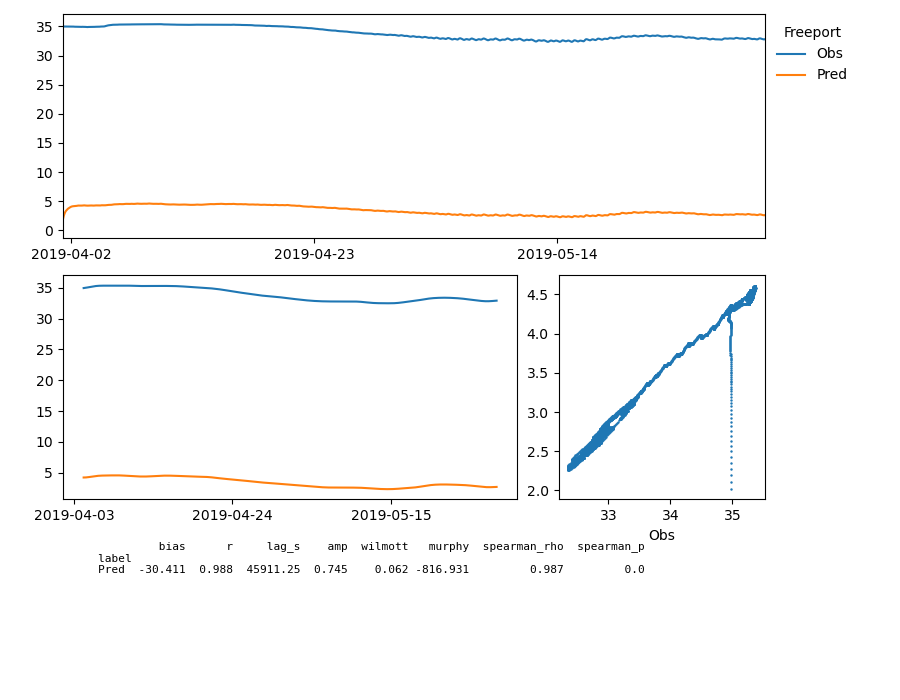

{'bias': -30.410688725767415, 'r': 0.9881025950872774, 'lag': numpy.timedelta64(45382500338,'us'), 'lag_s': 45382.500338, 'amp': 0.7451661197727055, 'wilmott': 0.06244121856463747, 'murphy': -816.9308495889123, 'spearman_rho': 0.9874333977746577, 'spearman_p': 0.0}


In [38]:
if 1:
    for comp in comparisons:
        if isinstance(comp,StageCompare) and comp.name=="Freeport":
            comp.figure()
            print(comp.calc_metrics())
        

In [39]:
%matplotlib notebook

In [40]:
model=runs.model[0]
grid=model.grid
shore_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 298 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


In [42]:
# dataframe with metrics, locations
recs=[]
for comp in comparisons:
    xy=comp.plot_xy()
    rec=dict(name=comp.name,x=xy[0],y=xy[1],cls=comp.__class__.__name__)
    # include the metrics
    rec.update(comp.calc_metrics()) 
    recs.append(rec)
comp_df=pd.DataFrame(recs)
comp_df

INFO:usgs_nwis:Fetching 11455420_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11455420_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11455420_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Fetching 11447650_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447650_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447650_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313433_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313433_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313433_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337190_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337190_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11337190_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337080_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11337080_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11337080_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11336600_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11336600_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11336600_60_2019-06-01_2019-07-01.nc
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rustyh/src/stompy/stompy/model/data_comparison.py:294: RuntimeWarning: divide by zero encountered in scalar divide
  metrics['amp']=np.std(x.values[valid]) / np.std(ref.values[valid])
/home/rustyh/src/stompy/stompy/utils.py:1172: RuntimeWarning: divide by zero encountered in scalar divide
  ms=1 - np.mean( (m-o)**2 )/np.mean( (xref-o)**2 )
/home/rustyh/mambaforge/envs/general310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficien

Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447905_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447905_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447905_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447903_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447903_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447903_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447890_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447890_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447890_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313460_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313460_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313460_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11304810_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11304810_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11304810_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11312672_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11312672_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11312672_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313315_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11313315_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11313315_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447850_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447850_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447850_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Fetching 11447830_65_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447830_65_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447830_65_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Fetching 11447830_60_2019-04-01_2019-05-01.nc


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:usgs_nwis:Fetching 11447830_60_2019-05-01_2019-06-01.nc
INFO:usgs_nwis:Fetching 11447830_60_2019-06-01_2019-07-01.nc
INFO:usgs_nwis:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:usgs_nwis:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:usgs_nwis:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


INFO:noaa_coops:Cached   2019-04-01 00:00:00 -- 2019-05-01 00:00:00
INFO:noaa_coops:Cached   2019-05-01 00:00:00 -- 2019-06-01 00:00:00
INFO:noaa_coops:Cached   2019-06-01 00:00:00 -- 2019-07-01 00:00:00


Inferred time period: 2019-04-01T00:00:00.000000000 to 2019-06-01T00:00:00.000000000


,name,x,y,cls,bias,r,lag,lag_s,amp,wilmott,murphy,spearman_rho,spearman_p,error
0,Rio Vista (SRV),615117.0,4224383.0,StageCompare,-0.371080,0.978442,-1 days +23:58:15,-105.000000,0.891111,0.756033,-0.270286,0.978656,0.0,NaN
1,Rio Vista (SRV),615232.941,4224588.2913,FlowCompare,-113.185253,0.981937,-1 days +23:49:14.999996,-645.000004,1.031829,0.989829,0.958328,0.986117,0.0,NaN
2,Freeport,630728.0,4257433.0,StageCompare,-30.410689,0.988103,0 days 12:36:22.500338,45382.500338,0.745166,0.062441,-816.930850,0.987433,0.0,NaN
3,Freeport,630579.5147,4257482.9321,FlowCompare,1.259676,0.992283,0 days 02:36:30.000069,9390.000069,0.991484,0.996111,0.984617,0.989689,0.0,NaN
4,RYI (near match),616561.0,4230315.0,StageCompare,-1.488069,0.978514,0 days 00:02:00,120.000000,0.938850,0.310845,-20.297708,0.978872,0.0,NaN
5,Dutch Slough,616873.419,4208070.624,StageCompare,-0.279599,0.973624,-1 days +23:40:44.999992,-1155.000008,0.964025,0.806875,0.030783,0.974235,0.0,NaN
6,Dutch Slough,616873.419,4208070.624,FlowCompare,-8.432922,0.965903,-1 days +23:33:14.999989,-1605.000011,0.887095,0.978463,0.924355,0.944205,0.0,NaN
7,Jersey Point,614542.562,4212134.93,StageCompare,-0.239809,0.974870,-1 days +23:45:44.999994,-855.000006,0.955491,0.841529,0.257411,0.974846,0.0,NaN
8,Jersey Point,614542.562,4212134.93,FlowCompare,-188.896546,0.965585,-1 days +23:31:07.499988,-1732.500012,0.819072,0.971427,0.906697,0.968249,0.0,NaN
9,Threemile Slough,615245.377,4218025.111,StageCompare,-0.289200,0.976936,-1 days +23:46:37.499995,-802.500005,0.957354,0.797827,-0.030071,0.977053,0.0,NaN


In [52]:
# Map showing stage calibration across the domain
def fig_stations(comp_df,hue=None,label='name',clim=None,fmt="%s",
                 negative_parens=False,cls=None):
    fig,ax=plt.subplots()
    plot_wkb.plot_wkb(shore_poly,ax=ax,ec='0.7',lw=0.5,fc='0.9')
    fig.subplots_adjust(0,0,1,1)

    ax.axis('equal')
    ax.axis("off")

    if cls is not None:
        subset=comp_df[ comp_df.cls==cls ]
    else:
        subset=comp_df
        
    for rec in subset.itertuples():
        if np.isnan(rec.x): continue
        ax.plot(rec.x,rec.y,'ro',ms=3)
        if label:
            v=getattr(rec,label)
            if negative_parens and v<0:
                s='(%s)'%( fmt%(-v))
            else:
                s=fmt%v
            ax.text(rec.x,rec.y,s)
    return fig

<IPython.core.display.Javascript object>


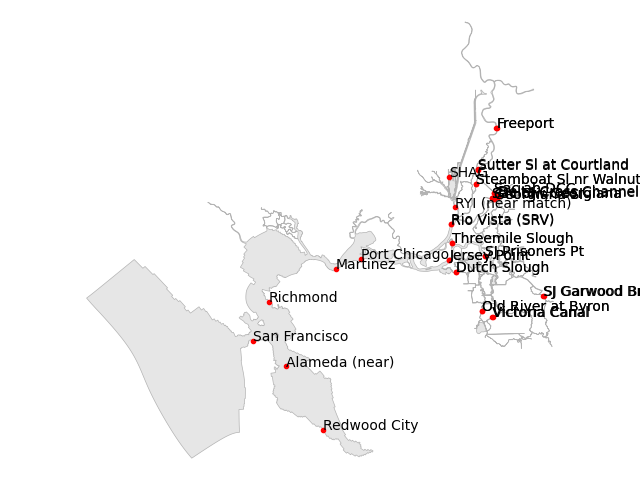

In [53]:
# Station locations with names
fig=fig_stations(comp_df,cls=None) 

<IPython.core.display.Javascript object>


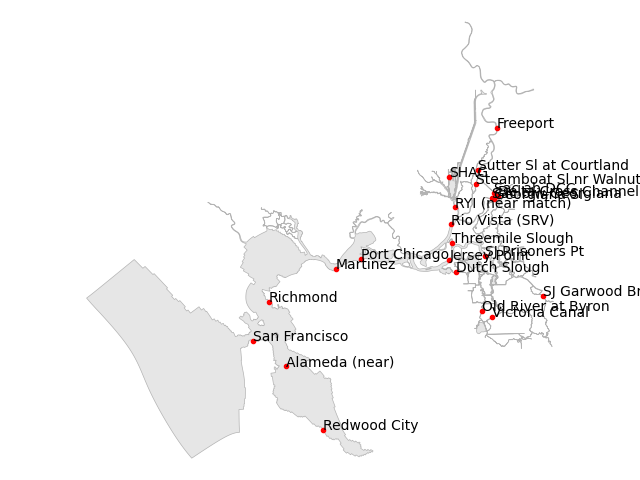

In [57]:
fig=fig_stations(comp_df,cls='StageCompare') 

<IPython.core.display.Javascript object>


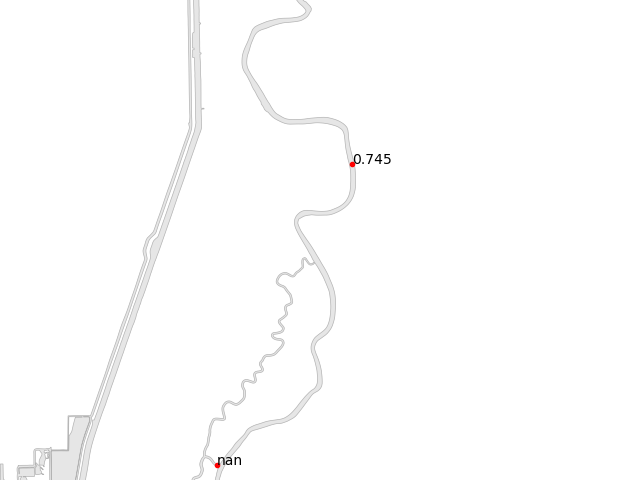

In [58]:
# WSE amplitude
# v011: amplitude acceptable throughout the Bay. Too strong
# in the W and S Delta, then weak going up mainstem Sac. DCC too strong.ma

fig=fig_stations(comp_df,label='amp',fmt="%.3f",cls="StageCompare") 

<IPython.core.display.Javascript object>


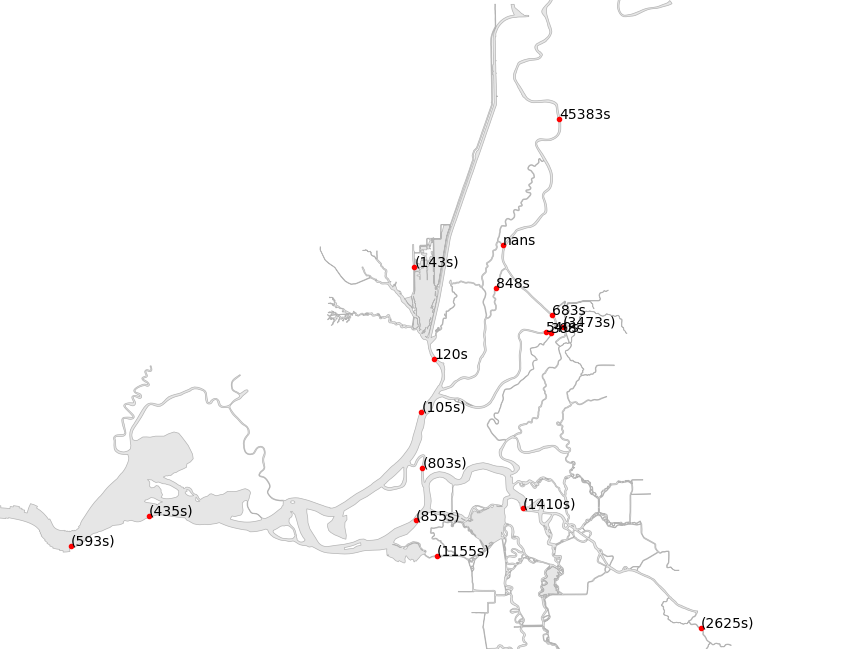

In [59]:
# WSE lag - SF is 1470s late, but propagation appears too fast
# through the Bay.
# Switched to PR tides, and now it's 585s early at SF, though amplitudes
# are still pretty bad.
# v011: Adjusted PR tides for amplitude, but I got the sign wrong
#   on the lag adjustment, and it went from -585s to -1300s.
# v019: SF is 533s late, and port chicago 383s early.
# v020: A little slow into south bay, decent into North Bay.
#  and decent into western Delta. Best yet. Attenuated going south,
#  so could decrease friction. Slightly attenuated going north.
fig=fig_stations(comp_df,label='lag_s',fmt="%.0fs",cls="StageCompare",negative_parens=True)

<IPython.core.display.Javascript object>


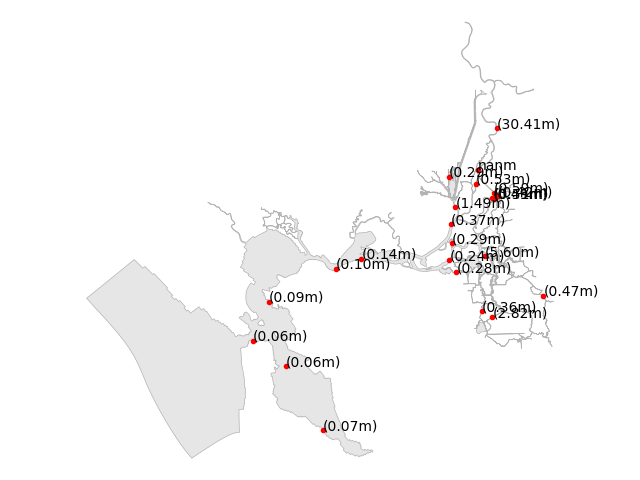

In [60]:
# WSE bias. Okay-ish in the Bay. Model is either too high in the Delta by
# 0.3m, or there is a datum issue with USGS measurements.
fig=fig_stations(comp_df,label='bias',fmt="%.2fm",cls="StageCompare",negative_parens=True)

<IPython.core.display.Javascript object>


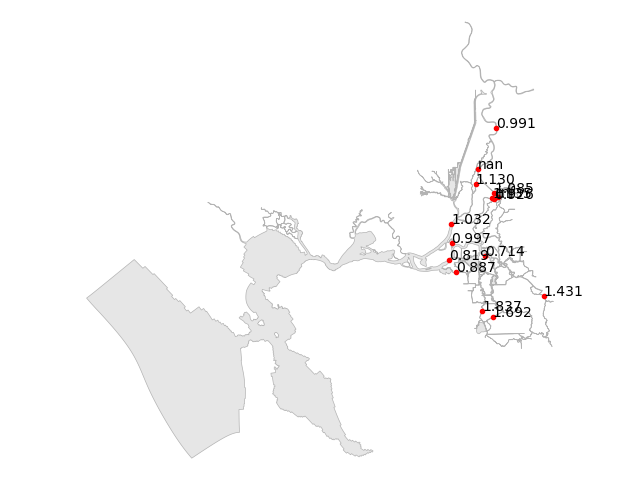

In [61]:
# Flow amplitude
# too small everywhere. This will improve with better amplitude
# on the BC.
fig=fig_stations(comp_df,label='amp',fmt="%.3f",cls="FlowCompare")

<IPython.core.display.Javascript object>


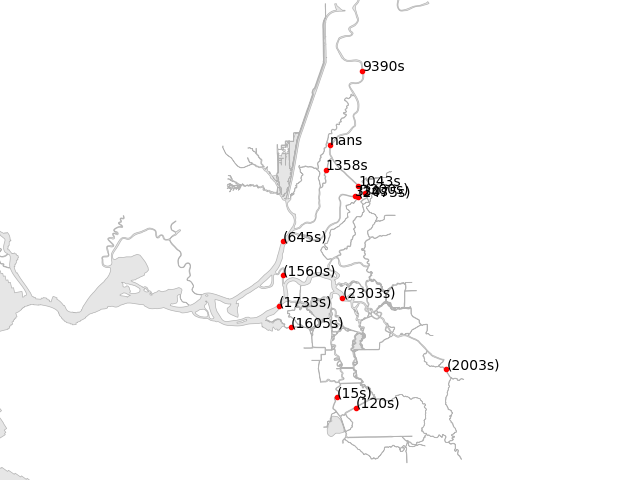

In [65]:
# Flow lag
fig=fig_stations(comp_df,label='lag_s',fmt="%.0fs",cls="FlowCompare", negative_parens=True)

<IPython.core.display.Javascript object>


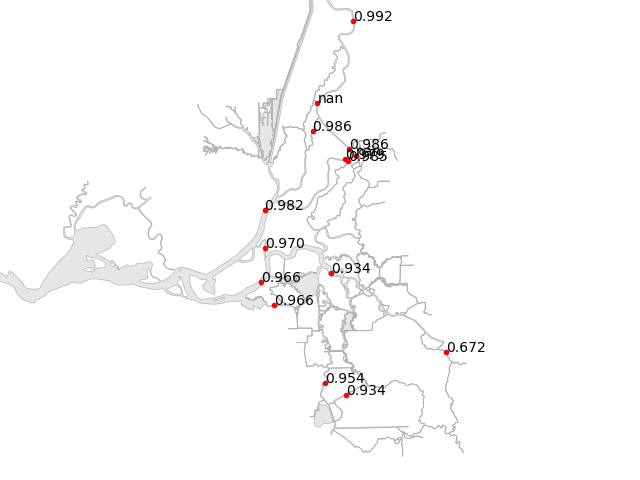

In [66]:
# Flow R
fig=fig_stations(comp_df,label='r',fmt="%.3f",cls="FlowCompare",negative_parens=True)